In [2]:
DATAPATH = '../data/'
XFERPATH = '~/downloads/'  # To transfer files from Google Colab
FNAME = 'embeds_agg.csv'

In [3]:
frompath = XFERPATH + FNAME
topath = DATAPATH + FNAME
!cp $frompath $topath

In [4]:
import lightgbm as lgb
import pandas as pd
import gender_guesser.detector as gender
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [116]:
df = pd.read_csv(DATAPATH+FNAME,index_col=[0,1],parse_dates=['time']).drop(['text'],axis=1)
df.head().iloc[:,:7]

,,name,male,embed0,embed1,embed2,embed3,embed4
id,time,,,,,,,
425472153,2019-05-25 20:24:48+00:00,Queen K,False,9156,-31075,-21194,41023,33810
1081873499621273601,2019-05-25 20:24:48+00:00,Alexandru Constantin,True,-34055,62140,-33476,1849,42774
987721418,2019-05-25 20:24:48+00:00,Susie Carmichael,False,-38618,12734,6150,6856,29976
980758839770451973,2019-05-25 20:24:52+00:00,Princess Sih.,False,-19252,-1482,-14205,-25178,-47939
838620336367218692,2019-05-25 20:24:53+00:00,Reid Kisselback,True,-40698,32644,3243,-35412,61766


In [117]:
print(df.shape)
df.index.get_level_values(1).min(), df.index.get_level_values(1).max()

(29678, 514)


(Timestamp('2019-05-21 17:50:48+0000', tz='UTC'),
 Timestamp('2019-05-26 12:53:53+0000', tz='UTC'))

In [118]:
df = df.sort_index(level='time')
df.head().iloc[:,:7]

,,name,male,embed0,embed1,embed2,embed3,embed4
id,time,,,,,,,
211806644,2019-05-21 17:50:48+00:00,Tabitha Rayne,False,36840,45825,-8880,20461,33486
1703564846,2019-05-21 17:50:48+00:00,Dimitri 🖤,True,-42156,32908,-17450,3590,-43536
971515498411241472,2019-05-21 17:50:48+00:00,Paola Vela,False,68532,13781,-52797,555,-125
21947445,2019-05-21 17:50:49+00:00,Nathalie,False,42295,-7144,-4412,-29190,31147
621596924,2019-05-21 17:50:49+00:00,Evan Boland,True,47176,-5129,-26225,-38181,-17701


In [119]:
n_train = int(.6*df.shape[0])
n_val = int(.2*df.shape[0])
n_test = df.shape[0] - n_val - n_train
train_ids = set(df.index.get_level_values(0)[:n_train])
val_ids = set(df.index.get_level_values(0)[n_train:n_train+n_val]) - train_ids
test_ids = set(df.index.get_level_values(0)[n_train+n_val:]) - train_ids - val_ids

In [120]:
len(train_ids), len(val_ids), len(test_ids)

(17403, 5680, 5611)

In [121]:
df_train = df.iloc[:n_train,:].copy()
df_valid = df.iloc[n_train:n_train+n_val,:].copy()
df_test = df.iloc[n_train+n_val:,:].copy()
df_train.shape, df_valid.shape, df_test.shape

((17806, 514), (5935, 514), (5937, 514))

In [122]:
train_select = [v in train_ids for v in df_train.index.get_level_values(0).values.tolist()]
valid_select = [v in val_ids for v in df_valid.index.get_level_values(0).values.tolist()]
test_select = [v in test_ids for v in df_test.index.get_level_values(0).values.tolist()]
df_train = df_train[train_select]
df_valid = df_valid[valid_select]
df_test = df_test[test_select]
df_train.shape, df_valid.shape, df_test.shape

((17806, 514), (5775, 514), (5724, 514))

In [123]:
df_train.index.get_level_values(1).min(), df_train.index.get_level_values(1).max()

(Timestamp('2019-05-21 17:50:48+0000', tz='UTC'),
 Timestamp('2019-05-25 11:55:21+0000', tz='UTC'))

In [124]:
df_valid.index.get_level_values(1).min(), df_valid.index.get_level_values(1).max()

(Timestamp('2019-05-25 11:55:22+0000', tz='UTC'),
 Timestamp('2019-05-26 06:32:23+0000', tz='UTC'))

In [125]:
df_test.index.get_level_values(1)[0], df_test.index.get_level_values(1)[-1]

(Timestamp('2019-05-26 06:32:25+0000', tz='UTC'),
 Timestamp('2019-05-26 12:53:53+0000', tz='UTC'))

In [126]:
ids0 = set(df_train.index.get_level_values(0))
ids1 = set(df_valid.index.get_level_values(0))
ids2 = set(df_test.index.get_level_values(0))
ids0.intersection(ids1), ids1.intersection(ids2), ids0.intersection(ids2)

(set(), set(), set())

In [127]:
n_males_train = df_train.male.sum()
n_females_train = df_train.shape[0] - n_males_train
n_males_train, n_females_train

(11146, 6660)

In [128]:
n_males_valid = df_valid.male.sum()
n_females_valid = df_valid.shape[0] - n_males_valid
n_males_valid, n_females_valid

(3612, 2163)

In [129]:
n_males_test = df_test.male.sum()
n_females_test = df_test.shape[0] - n_males_test
n_males_test, n_females_test

(3643, 2081)

In [130]:
n_each_train = min(n_males_train, n_females_train)
n_each_valid = min(n_males_valid, n_females_valid)
n_each_test = min(n_males_test, n_females_test)
n_each_train, n_each_valid, n_each_test

(6660, 2163, 2081)

In [131]:
df_train_m = df_train[df_train.male].copy().sample(n_each_train)
df_train_f = df_train[~df_train.male].copy().sample(n_each_train)
df_valid_m = df_valid[df_valid.male].copy().sample(n_each_valid)
df_valid_f = df_valid[~df_valid.male].copy().sample(n_each_valid)
df_test_m = df_test[df_test.male].copy().sample(n_each_test)
df_test_f = df_test[~df_test.male].copy().sample(n_each_test)
xy_train = pd.concat([df_train_m, df_train_f]).sample(frac=1)
xy_valid = pd.concat([df_valid_m, df_valid_f]).sample(frac=1)
xy_test = pd.concat([df_test_m, df_test_f]).sample(frac=1)

In [132]:
xy_train.shape, xy_valid.shape, xy_test.shape

((13320, 514), (4326, 514), (4162, 514))

In [133]:
xy_train.male.sum(), xy_valid.male.sum(), xy_test.male.sum()

(6660, 2163, 2081)

In [134]:
X_train = xy_train.drop(['name','male'],axis=1).values
y_train = 1*xy_train.male.values
X_valid = xy_valid.drop(['name','male'],axis=1).values
y_valid = 1*xy_valid.male.values
X_test = xy_test.drop(['name','male'],axis=1).values
y_test = 1*xy_test.male.values

In [219]:
d_train = lgb.Dataset(X_train, label=y_train)
params = {}
params['objective'] = 'binary'
params['learning_rate'] = .02
params['sub_feature'] = .4
params['lambda_l1'] = 5
params['lambda_l2'] = 1
#params['bagging_freq'] = 10
#params['bagging_fraction'] = 0.95

#params['min_data'] = 20        # min_data_in_leaf
params['max_depth'] = 6

nboost=40

reg = lgb.train(params, d_train, nboost)

In [220]:
y_train_pred = reg.predict(X_train)
f1_score(y_train, y_train_pred>.5)

0.6834045059637756

In [221]:
y_pred = reg.predict(X_valid)
print( confusion_matrix(y_valid, (y_pred>.5)) )
f1_score(y_valid, y_pred>.5)

[[1300  863]
 [ 813 1350]]


0.6170018281535649

In [222]:
# .61700

In [223]:
y_test_pred = reg.predict(X_test)
print( confusion_matrix(y_test, (y_test_pred>.5)) )
f1_score(y_test, y_test_pred>.5)

[[1282  799]
 [ 815 1266]]


0.6107091172214182

In [224]:
accuracy_score(y_test, y_test_pred>.5)

0.6122056703507929

In [225]:
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

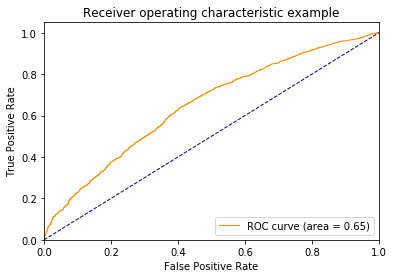

In [226]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()